# **CONSTANTS & IMPORTS**

Constants

In [91]:
EPOCHS = 300
LEARNING_RATE = 0.01
MANUAL_SEED = 12345
HIDDEN_NODE_COUNT = 64
DATASPLIT = 150
BATCH_SIZE_TRAINING = 64
BATCH_SIZE_TESTING = 1

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\theis\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\pylab.py:162: UserWarning:

pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy



# **Dataset import**

In [92]:
import os
import torch
import torch_geometric

from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader



dataset = TUDataset(root='dataset/Mutag', name='MUTAG')

data_details = {
    "num_node_features": dataset.num_node_features,
    "num_edge_features": dataset.num_edge_features,
    "num_classes": dataset.num_classes,
    "num_node_labels": dataset.num_node_labels,
    "num_edge_labels": dataset.num_edge_labels,
}

In [93]:
print(data_details)

{'num_node_features': 7, 'num_edge_features': 4, 'num_classes': 2, 'num_node_labels': 7, 'num_edge_labels': 4}


# **Getting device**


In [94]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    # MPS is currently slower than CPU due to missing int64 min/max ops
    device = torch.device('cpu')
else:
    device = torch.device('cpu')
print(device)

cuda


# **DATA SPLITTING**

Shuffle data (optional)

In [95]:
dataset = dataset.shuffle()

Create training set and test set (size defined in constants)

In [96]:
# Allocate for training
train_dataset = dataset[:DATASPLIT]
# Allocate the remainder for testing
test_dataset = dataset[DATASPLIT:]

# Define the data loaders. Used later for training, can be ignored for now
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE_TRAINING, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE_TESTING, shuffle=False)

%run visualize.py

In [97]:
print(len(train_dataset))
print(len(test_dataset))

150
38


#  **GRAPH VISUALIZATION EXAMPLE**

In [98]:
import networkx as nx
from visualize import GraphVisualization

def create_graph(graph):
    g = to_networkx(graph)
    pos = nx.spring_layout(g)
    vis = GraphVisualization(
        g,
        pos,
        node_text_position="top left",
        node_size=20,
    )
    fig = vis.create_figure()
    return fig


fig = create_graph(dataset[0])
fig.show()

# **GNN MODEL**

Imports


In [99]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

Model definition


In [100]:

class GCN(torch.nn.Module):
    def __init__(self, in_features=dataset.num_node_features, hidden_channels=HIDDEN_NODE_COUNT, outfeatures = 2):
        super(GCN, self).__init__()

        # Input layer
        self.conv1 = GCNConv(in_features, hidden_channels)

        # Hidden layers
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        #self.conv3 = GCNConv(hidden_channels, hidden_channels)
        #self.conv4 = GCNConv(hidden_channels, hidden_channels)
        #self.conv5 = GCNConv(hidden_channels, hidden_channels)

        # Output layer
        self.lin = Linear(hidden_channels, outfeatures)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        #x = self.conv3(x, edge_index)
        #x = x.relu()
        #x = self.conv4(x, edge_index)
        #x = x.relu()
        #x = self.conv5(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

super model

In [101]:
class SuperModel():
    def __init__(self, model: GCN, loss, optim):
        self.model = model
        self.loss_function = loss
        self.optimizer = optim
    

Returned data model

In [102]:
class TrainData():
    def __init__(self):
        self.train_losses = []
        self.train_accuracies = []
        self.train_labels = []
        self.train_scores = []
        
class TestData():
    def __init__(self):
        self.test_losses = []
        self.test_accuracies = []
        self.test_scores = []
        self.test_labels = []

# **TRAINING & Test**

In [103]:
from tqdm import trange

Basic model training

In [104]:
#def hyperParameterTester(hc=HIDDEN_NODE_COUNT, learn=LEARNING_RATE):
#    
#    torch.manual_seed(MANUAL_SEED)                              # Set manual seed
#    model = GCN(hidden_channels=hc)                             # Initilialize model
#    model.to(device=device)
#
#    optimizer = torch.optim.Adam(model.parameters(), lr=learn)  # Set optimizer with learning rate
#    loss_function = torch.nn.CrossEntropyLoss()                 # Set loss function
#
#    returnData = GCNData()
#
#    for epoch in trange(1, EPOCHS):
#        train()
#    test(train_loader)
#    
#    return returnData


## Train

In [105]:
def train(model_env: SuperModel, data_loader, train_data: TestData):
    model_env.model.train()
    loss_ = 0
    correct = 0
    i = 0

    for data in data_loader:  # Iterates the batches. We declared each batch to be of size 64
        data = data.to(device, non_blocking=True)
        # Calculate output, and get the maximum of those in order to obtain the predicted value
        out = model_env.model(data.x, data.edge_index, data.batch)
        cat = torch.argmax(out, dim=1)

        correct += int((cat == data.y).sum())  # Check against ground-truth labels.
        
        loss = model_env.loss_function(out, data.y)
        loss_ += loss.item()
        
        loss.backward()
        model_env.optimizer.step()
        model_env.optimizer.zero_grad()

        i+=1

        # Append actual and preddicted to respective array. Have to be converted to NumPy arrays in order to flatten them.
        # We flatten them as 1D arrays are required by SK in order to calculate and plot ROC AUC
        #This is not going to change for each epoch, so computational power is wasted here...
        arrayLabel = np.array(data.y.to('cpu'))
        for value in arrayLabel.flatten():
            train_data.train_labels.append(value)

        arrayCat = np.array(cat.to('cpu'))
        for value in arrayCat.flatten():
            train_data.train_scores.append(value)

    #tt.set_description("loss: %2f. accuracy %2f." % (loss, correct/len(train_loader.dataset)))
    train_data.train_losses.append(loss_/ i)
    train_data.train_accuracies.append(correct/len(train_loader.dataset))

## Test

In [118]:
def test(model_env: SuperModel, data_loader, test_data: TestData):
    model_env.model.eval()
    correct = 0
    loss_ = 0
    i = 0
    for data in data_loader:  # Iterate in batches over the training/test dataset.
        data = data.to(device, non_blocking=True)
        out = model_env.model(data.x, data.edge_index, data.batch)
        cat = torch.argmax(out, dim=1)

        correct += int((cat == data.y).sum())  # Check against ground-truth labels.

        loss = model_env.loss_function(out, data.y)
        loss_ += loss.item()

        i+=1

        arrayLabel = np.array(data.y.to('cpu'))
        for value in arrayLabel.flatten():
            test_data.test_labels.append(value)

        arrayCat = np.array(cat.to('cpu'))
        for value in arrayCat.flatten():
            test_data.test_scores.append(value)
        
    
    test_data.test_losses.append(loss_/ i)
    test_data.test_accuracies.append(correct/len(data_loader.dataset))

# **PLOTTING** 

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.style as mplstyle
import sklearn
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

**Plotting helper functions** 

In [108]:
def GraphPrettifier(figname, ylabel, title):
    figure = plt.figure(figname)
    figure.patch.set_facecolor('lightgray')
    plt.xlabel("# Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.legend()

# Used for prettier graph
def AvgCalculator(data, numChunks):
    averageOfData = []
    chunkSize = len(data) // numChunks
    for i in range(0, len(data), chunkSize):
        chunk = data[i:i+chunkSize]
        chunkAvg = sum(chunk) / len(chunk)
        averageOfData.append(chunkAvg)
    return averageOfData

# ROC AUC PLOT
def plotROCAUC(labels, scores, title, ax):
    # roc_auc = roc_auc_score(labels, scores)

    fpr, tpr, _ = metrics.roc_curve(labels,  scores)
    auc = metrics.roc_auc_score(labels, scores)
    ax.set_title(title)
    ax.plot(fpr,tpr)
    ax.legend(["auc="+str(round(auc, 2))], handlelength=0, handletextpad=0)

    # RocCurveDisplay.from_predictions(labels, scores)

    #plt.show()

Create a class for plotting parameters

In [109]:
class PP():
    def __init__(self, value, colour):
        self.value = value
        self.colour = colour

**Function for plotting the basic graph**

In [110]:
def PlotBasic():
    data = hyperParameterTester() # Get data
    AndreasPlot(data)
    X = np.arange(0, len(data.train_accuracies))
    plt.figure('g', figsize=[10,5])
    plt.plot(X, np.array(data.train_accuracies), c="indianred", label="Accuracy")
    plt.plot(X, np.array(data.train_losses), c="navy", label="Loss")
    GraphPrettifier('g', '', 'Accuracy and Loss')
    plt.show()

**Plotting learning rates**

In [111]:
def PlotOverLR(para, cleanGraph=False, numChunks = 50):
    EstNumData = (EPOCHS-1)*len(train_loader)
    X = np.arange(0, (EPOCHS-1)*len(train_loader)) if not cleanGraph else np.arange(0, EstNumData, EstNumData//numChunks)

    for p in para:
        data = hyperParameterTester(learn = p.value) # Get data

        plt.figure('Acc', figsize=[10,5]) # Activate figure with accuracy
        accuracies = np.array(data.train_accuracies)
        if not cleanGraph: plt.plot(X, accuracies, color=p.colour, label='Learning rate: {}'.format(p.value))

        plt.figure('Loss', figsize=[10,5]) # Activate figure with loss
        losses = np.array(data.train_losses)
        if not cleanGraph: plt.plot(X, losses, color=p.colour, label='Learning rate: {}'.format(p.value))

        if cleanGraph: # Taking averages for prettier graph
            averageAcc = AvgCalculator(accuracies, numChunks)
            averageLoss = AvgCalculator(losses, numChunks)
            
            plt.figure('Acc') # Activate figure with accuracy
            plt.plot(X, averageAcc, color=p.colour, label='Learning rate: {}'.format(p.value))
            plt.figure('Loss') # Activate figure with loss
            plt.plot(X, averageLoss, color=p.colour, label='Learning rate: {}'.format(p.value))

    script_dir = os.getcwd()
    save_dir = os.path.join(script_dir, 'Figures/LR/')

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    save_name = "Accuracy.pdf"
    GraphPrettifier('Acc', 'Accuracy', 'Accuracy with different learning rates')
    plt.savefig(save_dir + save_name)

    save_name = "Loss.pdf"
    GraphPrettifier('Loss', 'Loss', 'Loss with different learning rates')
    plt.savefig(save_dir + save_name)

    plt.show()

**Plotting node count**

In [112]:
def PlotOverHC(para, cleanGraph=False, numChunks = 50):
    EstNumData = (EPOCHS-1)*len(train_loader)
    X = np.arange(0, (EPOCHS-1)*len(train_loader)) if not cleanGraph else np.arange(0, EstNumData, EstNumData//numChunks)

    for p in para:
        data = hyperParameterTester(hc = p.value) # Get data

        plt.figure('Acc', figsize=[10,5]) # Activate figure with accuracy
        accuracies = np.array(data.train_accuracies)
        if not cleanGraph: plt.plot(X, accuracies, color=p.colour, label='# Neurons: {}'.format(p.value))

        plt.figure('Loss', figsize=[10,5]) # Activate figure with loss
        losses = np.array(data.train_losses)
        if not cleanGraph: plt.plot(X, losses, color=p.colour, label='# Neurons: {}'.format(p.value))

        if cleanGraph: # Taking averages for prettier graph
            averageAcc = AvgCalculator(accuracies, numChunks)
            averageLoss = AvgCalculator(losses, numChunks)
            
            plt.figure('Acc') # Activate figure with accuracy
            plt.plot(X, averageAcc, color=p.colour, label='# Neurons: {}'.format(p.value))
            plt.figure('Loss') # Activate figure with loss
            plt.plot(X, averageLoss, color=p.colour, label='# Neurons: {}'.format(p.value))

    script_dir = os.getcwd()
    save_dir = os.path.join(script_dir, 'Figures/HC/')

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    save_name = "Accuracy.pdf"
    GraphPrettifier('Acc', 'Accuracy', 'Accuracy with different neurons in the hidden layers')
    plt.savefig(save_dir + save_name)

    save_name = "Loss.pdf"
    GraphPrettifier('Loss', 'Loss', 'Loss with different neurons in the hidden layers')
    plt.savefig(save_dir + save_name)

    plt.show()

In [113]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from datetime import datetime

# ACCURACY PLOT
def plotAccuracy(losses, accuracies, title, ax):
    #fig, ax[0,1] = sub
    ax.set_title(title)
    ax.set_ylim(0, 1)
    ax.plot(losses)
    ax.plot(accuracies)
    ax.plot(losses, label="Loss")
    ax.plot(accuracies, label="Accuracy")
    ax.legend(loc="lower center")
    
    
    #plt.show()

def AndreasPlot(train_data: TrainData, test_data: TestData):
    plot_training = True
    plot_testing = True

    plot_accuracy = True
    plot_rocauc = True

    fig = plt.figure(figsize=(8, 6))

    gs = gridspec.GridSpec(3, 2)

    ax1 = plt.subplot(gs[0, :])



    table_data = [
        ["Seed", "Activation", "Weight Initializer", "Loss function", "Pooling", "Optimizer", "# GCN layers", "Neurons", "Split", "Epochs", "Batch Size", "LR"],
            [str(MANUAL_SEED), "ReLU", "Default", "C-Entropy", "GMax Pooling", "Adam", "3", "7, 64, 64, 64, 2", str(round(DATASPLIT/188, 2)), str(EPOCHS), "64", str(LEARNING_RATE)],
    ]

    table_data_1 = [table_data[0][:len(table_data[0]) // 2], table_data[1][:len(table_data[1]) // 2]]
    table_data_2 = [table_data[0][len(table_data[0]) // 2:], table_data[1][len(table_data[1]) // 2:]]

    # Create the first table in the top subplot (upper section)
    table_1 = ax1.table(cellText=table_data_1, cellLoc='center', loc='center')
    table_1.auto_set_font_size(False)
    table_1.set_fontsize(12)
    table_1.scale(1.2, 1.2)

    # Create the second table in the top subplot (lower section)
    table_2 = ax1.table(cellText=table_data_2, cellLoc='center', loc='bottom')
    table_2.auto_set_font_size(False)
    table_2.set_fontsize(12)
    table_2.scale(1.2, 1.2)



    # Hide axis and display the table
    #ax1 = plt.gca()
    ax1.axis('off')

    #divider_y = -1.1  # Adjust the y-coordinate as needed
    #ax1.axhline(divider_y, color='black')




    # Plot for train
    if(plot_training):
        if(plot_accuracy):
            #ax00 = ax[0, 0]
            ax00 = plt.subplot(gs[1, 0])

            plotAccuracy(train_data.train_losses, train_data.train_accuracies, "Training: Accuracy & Loss", ax00)

        if(plot_rocauc):
            #ax10 = ax[0, 1]
            ax10 = plt.subplot(gs[2, 0])

            plotROCAUC(train_data.train_labels, train_data.train_scores, "Training: ROC AUC", ax10)

    # Plot for test
    if(plot_testing):
        if(plot_accuracy):
            #ax01 = ax[1, 0]
            ax01 = plt.subplot(gs[1, 1])

            plotAccuracy(test_data.test_losses, test_data.test_accuracies, "Testing: Accuracy & Loss", ax01)

        if(plot_rocauc):
            #ax11 = ax[1, 1]
            ax11 = plt.subplot(gs[2, 1])

            plotROCAUC(test_data.test_labels, test_data.test_scores, "Testing: ROC AUC" ,ax11)

    now = datetime.now()

    title = "Model algorithm/parameter & performance profile. Profiled on {}.".format(now.strftime("%d/%m/%Y, %H:%M:%S"))

    fig.suptitle(title, fontsize=12, wrap=True)

    plt.tight_layout()

**Utilizing the two functions on some parameters**

In [114]:
LRparameters = {PP(0.1, 'lightsalmon'), PP(0.01, 'goldenrod'), PP(0.001, 'mediumaquamarine'), PP(0.005, 'rosybrown')}
HCparameters = {PP(5, 'firebrick'), PP(10, 'lightsalmon'), PP(20, 'darkgoldenrod'), PP(40, 'goldenrod'), PP(64, 'mediumaquamarine'), PP(100, 'black'), PP(200, 'rosybrown')}
#PlotOverLR(LRparameters, cleanGraph=True)
#PlotOverHC(HCparameters, cleanGraph=True)
#PlotBasic()

# Training a model

100%|██████████| 100/100 [00:05<00:00, 18.87it/s]


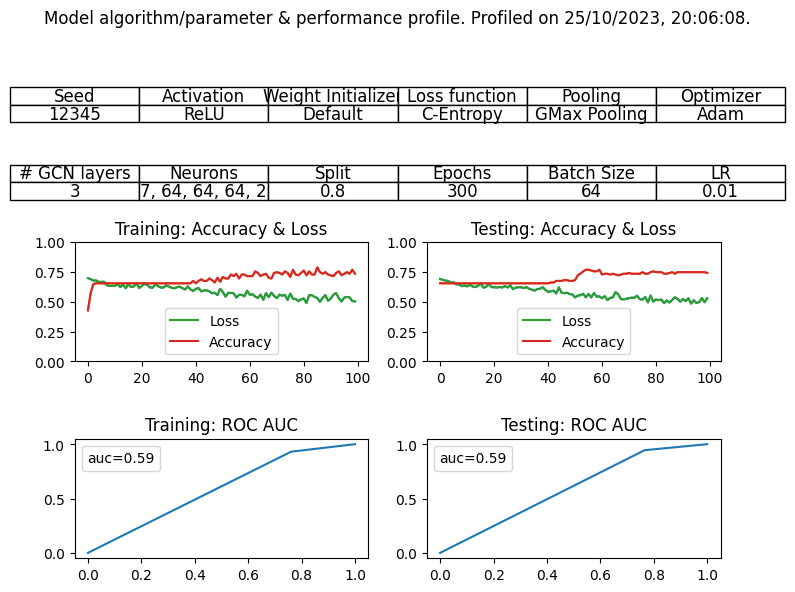

In [119]:
model = GCN(hidden_channels=64)
model.to(device=device)
loss_func = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
super_model = SuperModel(model=model, loss = loss_func, optim=optim)

train_data = TrainData()
test_data = TestData()

for i in trange(100):
    train(super_model, train_loader, train_data)
    test(super_model, train_loader, test_data)

AndreasPlot(train_data=train_data, test_data=test_data)